In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import shapely.ops as so
import pandas as pd
import numpy as np
import re
import importlib
import utils.serviceArea
importlib.reload(utils.serviceArea)
import utils.serviceArea as serviceArea

“Pedestrians can now enjoy a sheltered walk within 400m from all MRT stations and within 200m from bus interchanges, LRT stations and selected bus stops with high commuter volumes.”

In [2]:
# configure the place, network type, trip times, and travel speed
place = {"city": "Singapore", "country": "Singapore"}
network_type = "walk"
trip_times = [5, 10, 15, 20, 25]  # in minutes
# Accoridng to a British Council study, Singaporeans have the fastest walking speed in the world, 
# covering 18 meters in 10.55 seconds
travel_speed = 18/10.55 #m/s
travel_speed = travel_speed*3600/1000 #km/hour
# travel_speed = 4.5  # walking speed in km/hour

# Plot/save walking network

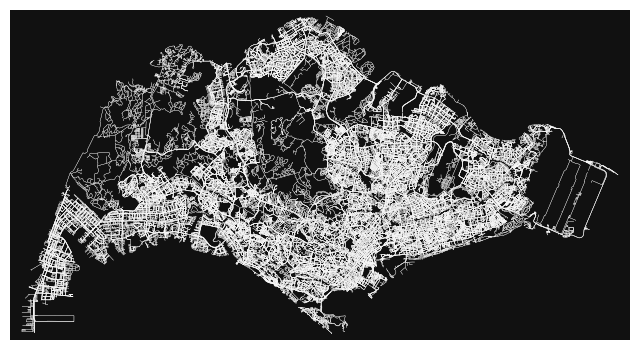

In [3]:
# # download/model a street network for some city then visualize it
# G = ox.graph_from_place(place, network_type=network_type)
# fig, ax = ox.plot_graph(G)

# # save walking network
save_dir = os.path.join(os.getcwd(),"data")
# if not os.path.exists(save_dir):
#     os.mkdir(save_dir)
filename = "SG_walk_network.graphml"
# # save graph to disk as GraphML file
# ox.save_graphml(G, filepath=os.path.join(save_dir,filename))

# load graph from disk
G = ox.load_graphml(os.path.join(save_dir,filename))
fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

# Load subzone shp file

In [15]:
subzone_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019SubzoneBoundaryNoSeaGEOJSON.shp")
subzone_shp.head()

Name                                         Descriptio SUBZONE_NO  \
0  kml_1  <center><table><tr><th colspan='2' align='cent...         12   
1  kml_2  <center><table><tr><th colspan='2' align='cent...          2   
2  kml_3  <center><table><tr><th colspan='2' align='cent...          3   
3  kml_4  <center><table><tr><th colspan='2' align='cent...          4   
4  kml_5  <center><table><tr><th colspan='2' align='cent...          5   

       SUBZONE_N SUBZONE_C                                           geometry  
0     DEPOT ROAD    BMSZ12  POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2...  
1    BUKIT MERAH    BMSZ02  POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28...  
2      CHINATOWN    OTSZ03  POLYGON Z ((103.84375 1.28508 0, 103.844 1.284...  
3        PHILLIP    DTSZ04  POLYGON Z ((103.84962 1.28412 0, 103.84955 1.2...  
4  RAFFLES PLACE    DTSZ05  POLYGON Z ((103.85253 1.28617 0, 103.85253 1.2...

EPSG:4326


<Axes: >

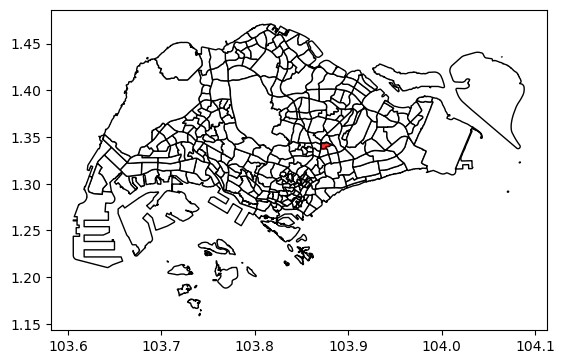

In [18]:
print(subzone_shp.crs)
ax = subzone_shp.plot(fc='white',ec='k')
subzone_shp[subzone_shp['SUBZONE_N'].str.contains("BIDADARI")].plot(ax=ax, fc='red',ec='k',alpha=0.8)

# Load planning area shp file

In [35]:
planningArea_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019_PlanningArea_Fixed.shp")
planningArea_shp.head()

Name                                         Descriptio  \
0   kml_1  <center><table><tr><th colspan='2' align='cent...   
1   kml_4  <center><table><tr><th colspan='2' align='cent...   
2  kml_12  <center><table><tr><th colspan='2' align='cent...   
3  kml_24  <center><table><tr><th colspan='2' align='cent...   
4  kml_27  <center><table><tr><th colspan='2' align='cent...   

              PLN_AREA_N PLN_AREA_C CA_IND                 _errors  \
0                  BEDOK         BD      N  Ring self-intersection   
1            BUKIT MERAH         BM      N  Ring self-intersection   
2            JURONG EAST         JE      N  Ring self-intersection   
3  NORTH-EASTERN ISLANDS         NE   None  Ring self-intersection   
4       SOUTHERN ISLANDS         SI      N  Ring self-intersection   

              layer                                               path  \
0  Fixed geometries  MultiPolygonZ?crs=EPSG:4326&field=Name:string(...   
1  Fixed geometries  MultiPolygonZ?crs=EPSG:4326&field=Name:string(...   
2  Fixed geometries  MultiPolygonZ?crs=EPSG:4326&field=Name:string(...   
3  Fixed geometries  MultiPolygonZ?crs=EPSG:4326&field=Name:string(...   
4  Fixed geometries  MultiPolygonZ?crs=EPSG:4326&field=Name:string(...   

                                            geometry  
0  POLYGON Z ((103.93208 1.30555 0, 103.93209 1.3...  
1  POLYGON Z ((103.82361 1.26018 0, 103.82361 1.2...  
2  MULTIPOLYGON Z (((103.70983 1.30775 0, 103.709...  
3  MULTIPOLYGON Z (((104.05483 1.43133 0, 104.054...  
4  MULTIPOLYGON Z (((103.83332 1.21666 0, 103.833...

<Axes: >

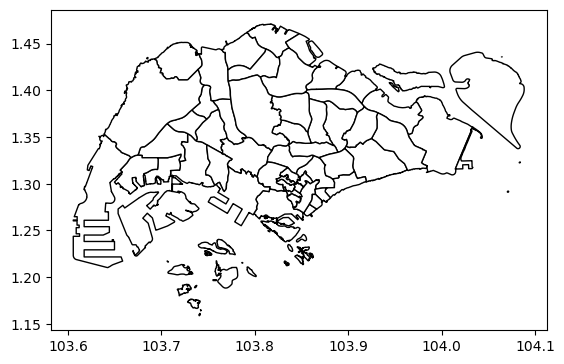

In [8]:
planningArea_shp.plot(fc="white",ec="k")

Check CRS

In [9]:
planningArea_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Load train station exits

PROJCS["SVY21",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",1.36666666666667],PARAMETER["central_meridian",103.833333333333],PARAMETER["scale_factor",1],PARAMETER["false_easting",28001.642],PARAMETER["false_northing",38744.572],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


<Axes: >

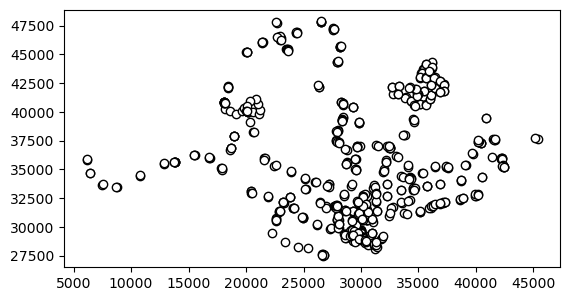

In [10]:
trainStationExit = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\TrainStationExit\Train_Station_Exit_Layer.shp")
print(trainStationExit.crs)
trainStationExit.plot(fc="w",ec="k")

#### Stations built after 2019

In [32]:
# trainStationExit[trainStationExit['stn_name'].str.contains("BRIGHT HILL")]
mrt_after_2019 = pd.read_csv(r"data\Stations_after_2019.csv")
def extract_stn_name(text):
    match = re.match(r"^(.*?)\s*\[", text)
    if match is not None:
        return match.group(1)
    else:
        return text
mrt_after_2019['STN_NAME'] = mrt_after_2019["Stations_after_2019"].apply(lambda x: extract_stn_name(x))
mrt_after_2019['STN_NAME'] = mrt_after_2019['STN_NAME'].str.upper() + ' MRT STATION'
mrt_after_2019

Stations_after_2019                        STN_NAME
0                    Hume [DT4]                HUME MRT STATION
1               Canberra [NS12]            CANBERRA MRT STATION
2         Woodlands North [TE1]     WOODLANDS NORTH MRT STATION
3         Woodlands South [TE3]     WOODLANDS SOUTH MRT STATION
4              Springleaf [TE4]          SPRINGLEAF MRT STATION
5                  Lentor [TE5]              LENTOR MRT STATION
6               Mayflower [TE6]           MAYFLOWER MRT STATION
7             Bright Hill [TE7]         BRIGHT HILL MRT STATION
8           Upper Thomson [TE8]       UPPER THOMSON MRT STATION
9           Stevens [DT10/TE11]             STEVENS MRT STATION
10                Napier [TE12]              NAPIER MRT STATION
11     Orchard Boulevard [TE13]   ORCHARD BOULEVARD MRT STATION
12           Great World [TE15]         GREAT WORLD MRT STATION
13              Havelock [TE16]            HAVELOCK MRT STATION
14  Outram Park [EW16/NE3/TE17]         OUTRAM PARK MRT STATION
15               Maxwell [TE18]             MAXWELL MRT STATION
16           Shenton Way [TE19]         SHENTON WAY MRT STATION
17   Marina Bay [NS27/CE2/TE20]          MARINA BAY MRT STATION
18    Gardens By the Bay [TE22]  GARDENS BY THE BAY MRT STATION
19           Tanjong Rhu [TE23]         TANJONG RHU MRT STATION
20           Katong Park [TE24]         KATONG PARK MRT STATION
21        Tanjong Katong [TE25]      TANJONG KATONG MRT STATION
22         Marine Parade [TE26]       MARINE PARADE MRT STATION
23        Marine Terrace [TE27]      MARINE TERRACE MRT STATION
24                Siglap [TE28]              SIGLAP MRT STATION

In [34]:
trainStationExit_pre2019 = trainStationExit[~trainStationExit['stn_name'].isin(mrt_after_2019['STN_NAME'].to_list())]
trainStationExit_pre2019

stn_name exit_code                     geometry
0    MACPHERSON MRT STATION    Exit A  POINT (34285.068 34322.985)
1    MACPHERSON MRT STATION    Exit B  POINT (34382.153 34231.904)
2    MACPHERSON MRT STATION    Exit C  POINT (34337.292 34190.603)
3      TONGKANG LRT STATION    Exit B  POINT (33872.145 41256.053)
4      TONGKANG LRT STATION    Exit A  POINT (33858.542 41234.065)
..                      ...       ...                          ...
587    BAYSHORE MRT STATION    Exit 1  POINT (40013.055 32688.872)
588    BAYSHORE MRT STATION    Exit 2  POINT (39947.586 32720.398)
589    BAYSHORE MRT STATION    Exit 3  POINT (39952.869 32873.448)
590    BAYSHORE MRT STATION    Exit 4  POINT (40170.433 32868.859)
591    BAYSHORE MRT STATION    Exit 5  POINT (40160.253 32799.231)

[489 rows x 3 columns]

# Load bus stops

<Axes: >

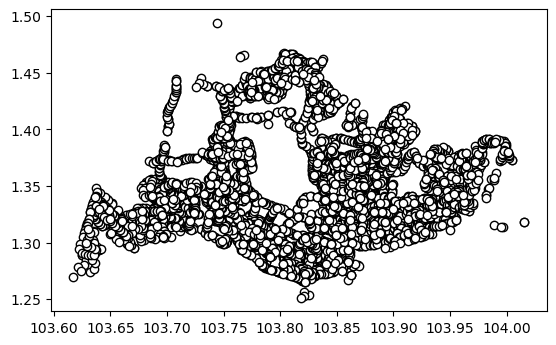

In [11]:
busStops = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\gtfs-feed-lta\stops.txt")
#convert pd to gpd
busStops = gpd.GeoDataFrame(
        busStops, geometry=gpd.points_from_xy(busStops.stop_lon, busStops.stop_lat), crs="EPSG:4326"
    )
busStops.plot(fc="w",ec="k")

### spatially join bus stops with planning area and subzone
- Remove TENGAH planning area and BIDADARI subzone

In [45]:
busStops_pre2019 = busStops.sjoin(planningArea_shp,how="left").rename(columns={"index_right":"index_PLN_AREA_N"})
busStops_pre2019 = busStops_pre2019.sjoin(subzone_shp,how="left").rename(columns={"index_right":"index_SUBZONE_N"})
print("Length of bus df: ", len(busStops_pre2019))
busStops_pre2019 = busStops_pre2019[~((busStops_pre2019['PLN_AREA_N'] == "TENGAH") | (busStops_pre2019['SUBZONE_N'] == "BIDADARI"))]

Length of bus df:  5251


## Inspect the walking road network nodes

103.83358042968563 1.303806873111928


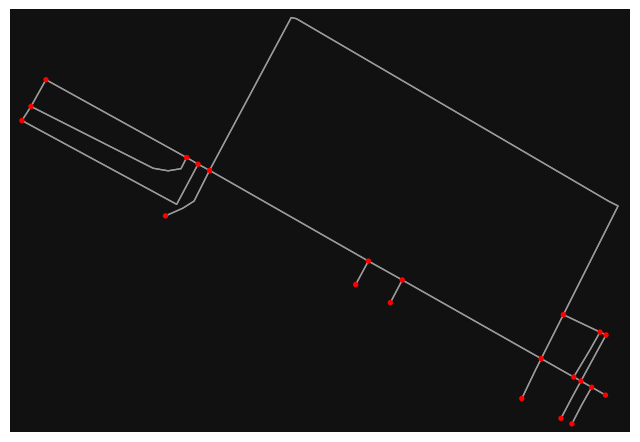

In [27]:
centroid = planningArea_shp.loc[42,"geometry"].centroid
lon, lat = centroid.xy
print(lon[0],lat[0])
G_pa = ox.graph_from_point((lat[0],lon[0]), dist=100,network_type=network_type)
fig, ax = ox.plot_graph(G_pa, node_color="r")

In [192]:
def plot_walking_busstop(G,bus_stops_df, train_exits_df, planning_area_df, ax = None):
    """ 
    Args:
        G (MultiDiGraph): graph of walking network
        train_exits_df (gpd): gpd of train_exits
        bus_stops_df (gpd): gpd of bus stops
        planning_area_df (gpd): planning area polygon
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # plot planning area
    
    polygon_proj = ox.projection.project_gdf(planning_area_df,# maintains polygon as a gdf instead of a pd.Series
                                            to_latlong=True
                                            )
    polygon_proj.plot(ax=ax,fc="gray", ec="gray")
    
    # plot network

    G_pa_proj = ox.projection.project_graph(G, to_latlong=True)
    
    ox.plot_graph(G_pa_proj,ax=ax,
                node_size=1,node_color="w",node_alpha=0.5,
                edge_color="w",
                show=False,close=False)
    
    # bus stops
    busStop_clip = gpd.clip(bus_stops_df,mask=planning_area_df)
    print(f'Number of bus stops: {busStop_clip.shape[0]}')
    if busStop_clip.shape[0] > 0:
        busStop_proj = ox.projection.project_gdf(busStop_clip,
                                                to_latlong=True
                                                )

        busStop_proj.plot(ax=ax,fc="blue", ec="blue",markersize=5,
                        label="Bus stops"
                        )
        
    # train station exits
    # reproject layer if crs is different
    if train_exits_df.crs != bus_stops_df.crs:
        print(train_exits_df.crs,bus_stops_df.crs)
        train_exits_df = train_exits_df.to_crs(bus_stops_df.crs)
    print(train_exits_df.crs,bus_stops_df.crs)
    trainExits_clip = gpd.clip(train_exits_df,mask=planning_area_df)
    print(f'Number of train exits: {trainExits_clip.shape[0]}')
    if trainExits_clip.shape[0] > 0:
        trainExits_proj = ox.projection.project_gdf(trainExits_clip,
                                                to_latlong=True
                                                )

        trainExits_proj.plot(ax=ax,fc="red", ec="red",markersize=5,
                        label="Train station exits"
                        )
        
    # set title
    ax.set_title(planning_area_df["PLN_AREA_N"].values[0])
    # if ax is None:
        # add legend
    if ax is None:
        plt.show()
    return

Number of bus stops: 289
PROJCS["SVY21",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",1.36666666666667],PARAMETER["central_meridian",103.833333333333],PARAMETER["scale_factor",1],PARAMETER["false_easting",28001.642],PARAMETER["false_northing",38744.572],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] EPSG:4326
EPSG:4326 EPSG:4326
Number of train exits: 27


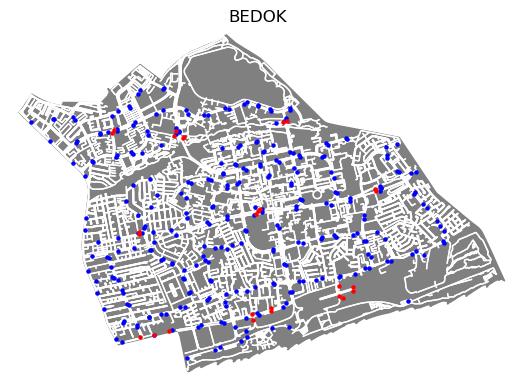

In [193]:
# Exclude the islands
SG_PA = planningArea_shp[~planningArea_shp['PLN_AREA_N'].str.contains("ISLAND")]
SG_PA = SG_PA.reset_index()
fig, ax = plt.subplots()
G_pa = ox.load_graphml(r"data\walk_network_BEDOK.graphml")
plot_walking_busstop(G=G_pa,bus_stops_df=busStops, 
                            train_exits_df=trainStationExit,
                            planning_area_df=SG_PA.iloc[[0],:], 
                            ax = ax)
plt.show()

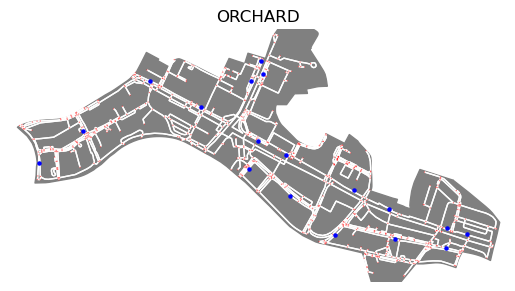

In [128]:
G_pa = ox.graph_from_polygon(planningArea_shp.loc[42,"geometry"], 
                                    network_type=network_type,
                                    )
# plot on ax
plot_walking_busstop(G=G_pa,bus_stops_df=busStops, 
                    planning_area_df=planningArea_shp.iloc[[42],:])

Number of bus stops: 289
PROJCS["SVY21",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",1.36666666666667],PARAMETER["central_meridian",103.833333333333],PARAMETER["scale_factor",1],PARAMETER["false_easting",28001.642],PARAMETER["false_northing",38744.572],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] EPSG:4326
EPSG:4326 EPSG:4326
Number of train exits: 27
Number of bus stops: 182
PROJCS["SVY21",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",1.36666666666667],PARAMETER["central_meridian",103.833333333333],PARAMETER["scale_factor",1],PARAMETER["false_eastin

C:\Users\hypak\AppData\Local\Temp\ipykernel_20844\1438104523.py:34: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  fig.legend(lines, labels, bbox_to_anchor = (0.5,-0.05), loc = 'lower center',ncol = len(lines),


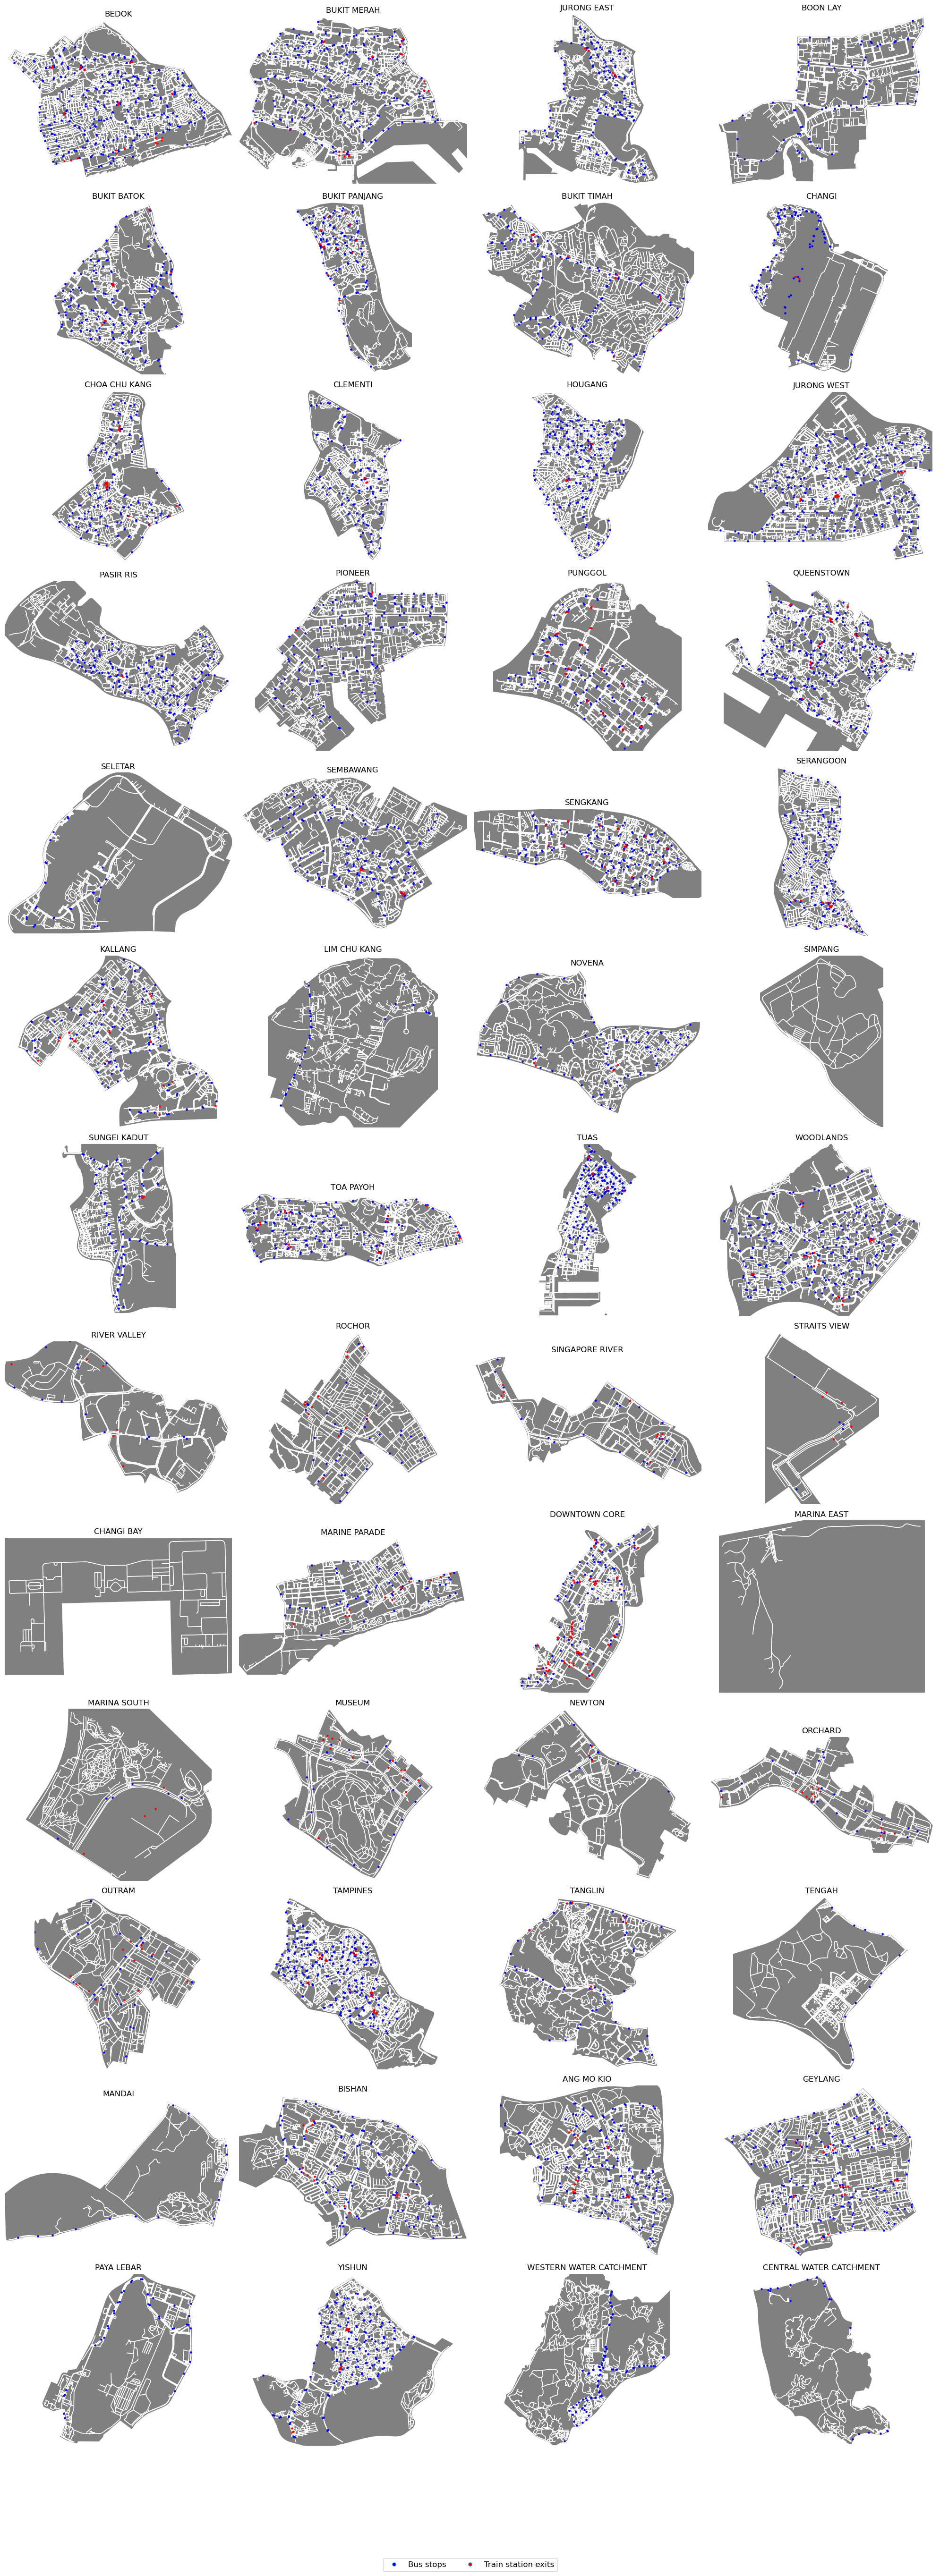

In [194]:
# # save walking network
save_dir = os.path.join(os.getcwd(),"data")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# Exclude the islands
SG_PA = planningArea_shp[~planningArea_shp['PLN_AREA_N'].str.contains("ISLAND")]
SG_PA = SG_PA.reset_index()
N_graphs = SG_PA.shape[0]
ncols = 4
nrows = N_graphs//ncols
fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*5,nrows*4))
for i,ax in enumerate(axes.flatten()):
    place = SG_PA.loc[i,'PLN_AREA_N']
    filename = f"walk_network_{place}.graphml"
    filepath=os.path.join(save_dir,filename)
    if os.path.exists(filepath):
        # load graph from disk
        G_pa = ox.load_graphml(filepath)
        try:
            # plot on ax
            plot_walking_busstop(G=G_pa,bus_stops_df=busStops, 
                                 train_exits_df=trainStationExit,
                                planning_area_df=SG_PA.iloc[[i],:], 
                                ax = ax)
        except Exception as e:
            print(f'{place} Error: {e}')

lines = [
        Line2D([0], [0], linestyle="none", marker="o", markersize=5, markerfacecolor=t.get_facecolor())
        for t in axes[0,0].collections[1:]
    ]
labels = [t.get_label() for t in axes[0,0].collections[1:]]
fig.legend(lines, labels, bbox_to_anchor = (0.5,-0.05), loc = 'lower center',ncol = len(lines),
           fontsize="large")
plt.tight_layout()
fp_save = os.path.join(save_dir,"planningArea_walking_busstops.png")
plt.savefig(fp_save, bbox_inches = 'tight')
plt.show()

# Isochrones

In [197]:
G_pa = ox.load_graphml(r"data\walk_network_BEDOK.graphml")


In [202]:
# get one color for busStops and trainStationExits
iso_colors = ox.plot.get_colors(n=2, cmap="plasma", start=0)
iso_colors

['#0d0887', '#f0f921']

### Get nearest bus and train nodes

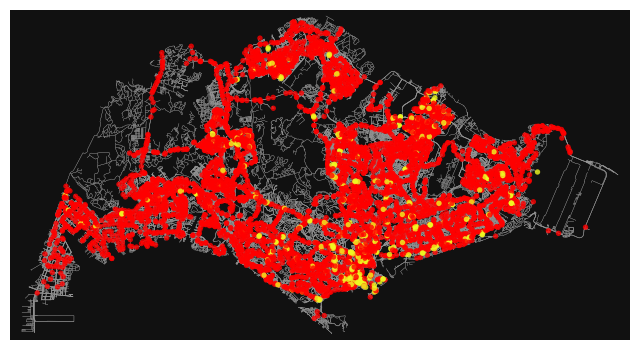

In [342]:
GSA = serviceArea.GetServiceArea(G,busStops,trainStationExit)
_ = GSA.get_publicTransport_nodes(plot=True, bus_c='red',train_c=iso_colors[1])

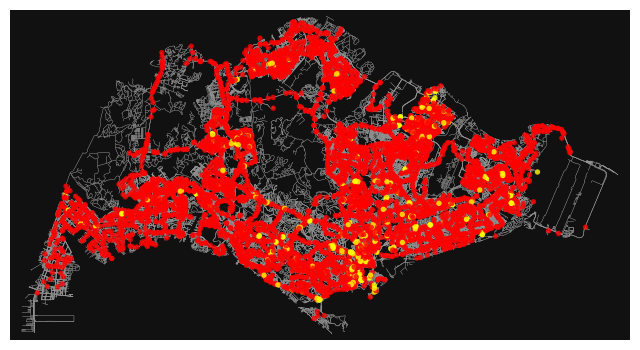

In [46]:
GSA = serviceArea.GetServiceArea(G,busStops_pre2019,trainStationExit_pre2019)
_ = GSA.get_publicTransport_nodes(plot=True, bus_c='red',train_c="yellow")

### Get bus and train service area nodes

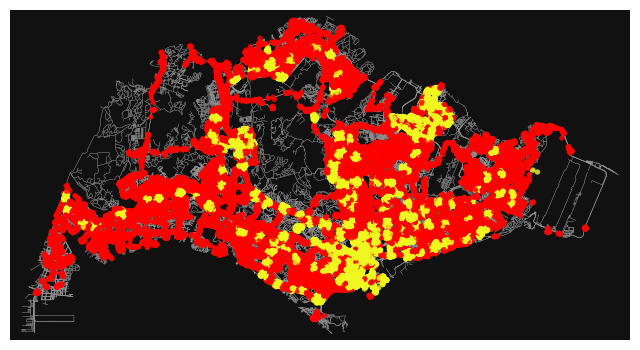

In [343]:
GSA = serviceArea.GetServiceArea(G,busStops,trainStationExit)
_ = GSA.get_serviceArea_nodes(plot=True, bus_c='red',train_c=iso_colors[1])

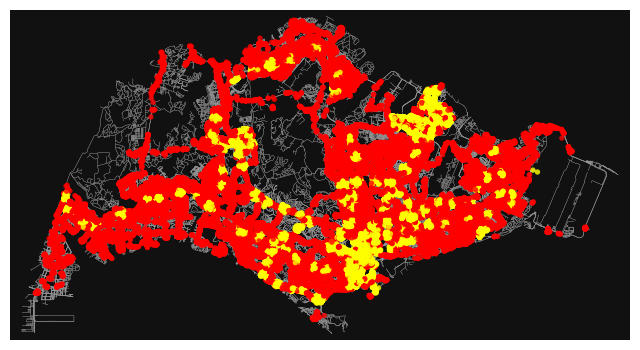

In [47]:
GSA = serviceArea.GetServiceArea(G,busStops_pre2019,trainStationExit_pre2019)
_ = GSA.get_serviceArea_nodes(plot=True, bus_c='red',train_c="yellow")

### Get service area polygons

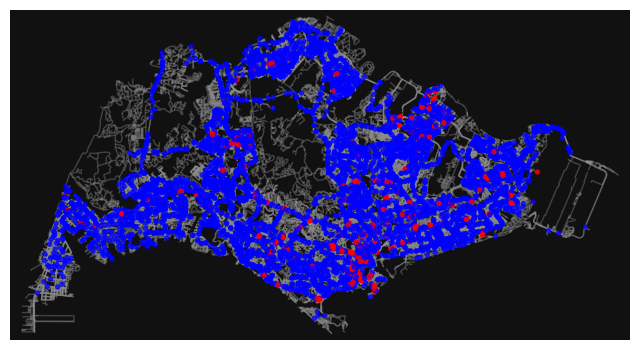

Area: 105.80540181640792 km2


105.80540181640792

In [48]:
save_dir = os.path.join(os.getcwd(),"data")
GSA = serviceArea.GetServiceArea(G,busStops_pre2019,trainStationExit_pre2019)
serviceArea = GSA.plot_serviceArea(plot=True)
serviceArea.to_file(os.path.join(save_dir,"SG_serviceArea_pre2019.shp"),driver='ESRI Shapefile')
GSA.calculate_serviceArea(serviceArea)

# Import service area shp file

In [49]:
serviceArea = gpd.read_file(r"data\SG_serviceArea_pre2019.shp")

Text(33.722222222222214, 0.5, 'Latitude')

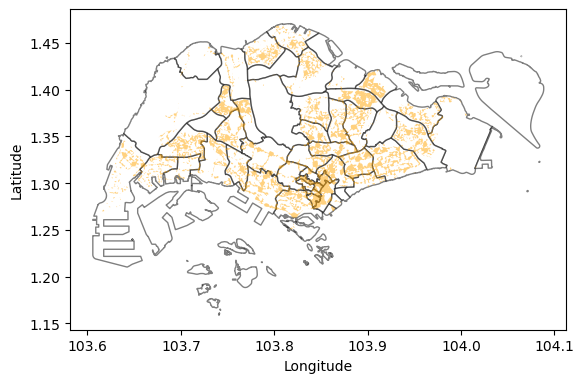

In [51]:
ax = planningArea_shp.plot(ec='k',fc='white',alpha=0.5)
serviceArea.plot(ax=ax,fc='orange',alpha=0.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

### Split service area based on planning area

In [ ]:
def calculate_serviceArea(serviceArea):
    """ 
    Args:
        serviceArea (gpd): polygon collection in a gdf that represents the union of the service area
    Returns:
        float: Area of service area in km2
    """
    serviceArea = serviceArea.to_crs({'proj':'cea'})
    area = serviceArea.geometry[0].area/10**6 # [0] for index 0, to avoid error, make sure the gdf has 1 item and reset_index() is applied
    print(f'Area: {area} km2')
    return area

serviceArea_planningArea = []
# Exclude the islands
SG_PA = planningArea_shp[~planningArea_shp['PLN_AREA_N'].str.contains("ISLAND")]
SG_PA = SG_PA.reset_index()
for i in range(len(SG_PA.index)):
    PLN_AREA_N = SG_PA['PLN_AREA_N'][i]
    PLN_AREA_C = SG_PA['PLN_AREA_C'][i]
    planningArea_polygon = SG_PA.iloc[[i],:].reset_index()
    planningArea_area = calculate_serviceArea(planningArea_polygon)
    # clip a gdf using a polygon
    sa = gpd.clip(serviceArea,SG_PA.geometry[i])
    
    try:
        area = calculate_serviceArea(sa)
        serviceArea_planningArea.append({'PLN_AREA_N':PLN_AREA_N,
                                        'PLN_AREA_C':PLN_AREA_C,
                                        'serviceArea_km2': area,
                                        'planningArea_km2': planningArea_area,
                                        'PublicTransitCatchmentFactor':area/planningArea_area})
    except Exception as e:
        serviceArea_planningArea.append({'PLN_AREA_N':PLN_AREA_N,
                                        'PLN_AREA_C':PLN_AREA_C,
                                        'serviceArea_km2': np.nan,
                                        'planningArea_km2': planningArea_area,
                                        'PublicTransitCatchmentFactor':np.nan})
# export area of service area for each planning area
save_dir = os.path.join(os.getcwd(),"data")
serviceArea_df = pd.DataFrame(serviceArea_planningArea)
serviceArea_df.to_csv(os.path.join(save_dir,"SG_serviceArea_pre2019.csv"),index=False)

Area: 21.73390513851583 km2
Area: 6.384394339201969 km2
Area: 14.461198067482805 km2
Area: 3.957760236375397 km2
Area: 17.860002967732196 km2
Area: 2.8107820663496033 km2
Area: 8.282763824111704 km2
Area: 0.843824358899547 km2
Area: 11.140156125955677 km2
Area: 3.003248781865259 km2
Area: 9.019929612876725 km2
Area: 2.2719459484263274 km2
Area: 17.51493652005161 km2
Area: 2.733888821174814 km2
Area: 41.470754135873165 km2
Area: 0.8241092760523144 km2
Area: 6.1172800729083345 km2
Area: 2.9677333387121583 km2
Area: 9.521312600469768 km2
Area: 2.1809046154193177 km2
Area: 13.933030938285723 km2
Area: 3.5704653083181292 km2
Area: 14.680284403515524 km2
Area: 4.783721352513755 km2
Area: 15.803115987427091 km2
Area: 2.6587667189572306 km2
Area: 12.219708759402753 km2
Area: 2.3071163620394457 km2
Area: 9.374260414032307 km2
Area: 3.3681947198108273 km2
Area: 21.683955598530673 km2
Area: 5.226944281411509 km2
Area: 10.848867725434875 km2
Area: 0.19502482154453138 km2
Area: 12.636192877848183 k

### Export to shapefile

In [411]:
serviceArea.to_file(os.path.join(save_dir,'SG_serviceArea.shp'),driver='ESRI Shapefile')

# Split service area based on subzone

In [54]:
def calculate_serviceArea(serviceArea):
    """ 
    Args:
        serviceArea (gpd): polygon collection in a gdf that represents the union of the service area
    Returns:
        float: Area of service area in km2
    """
    serviceArea = serviceArea.to_crs({'proj':'cea'})
    area = serviceArea.geometry[0].area/10**6 # [0] for index 0, to avoid error, make sure the gdf has 1 item and reset_index() is applied
    print(f'Area: {area} km2')
    return area

serviceArea_subzone = []
for i in range(len(subzone_shp.index)):
    SUBZONE_N = subzone_shp['SUBZONE_N'][i]
    SUBZONE_C = subzone_shp['SUBZONE_C'][i]
    planningArea_polygon = subzone_shp.iloc[[i],:].reset_index()
    planningArea_area = calculate_serviceArea(planningArea_polygon)
    # clip a gdf using a polygon
    sa = gpd.clip(serviceArea,subzone_shp.geometry[i])
    
    try:
        area = calculate_serviceArea(sa)
        serviceArea_subzone.append({'SUBZONE_N':SUBZONE_N,
                                        'SUBZONE_C':SUBZONE_C,
                                        'serviceArea_km2': area,
                                        'subzone_km2': planningArea_area,
                                        'SA_SZ_ratio':area/planningArea_area})
    except Exception as e:
        serviceArea_subzone.append({'SUBZONE_N':SUBZONE_N,
                                        'SUBZONE_C':SUBZONE_C,
                                        'serviceArea_km2': np.nan,
                                        'subzone_km2': planningArea_area,
                                        'SA_SZ_ratio':np.nan})
# export area of service area for each planning area
save_dir = os.path.join(os.getcwd(),"data")
serviceArea_df = pd.DataFrame(serviceArea_subzone)
serviceArea_df.to_csv(os.path.join(save_dir,"SG_serviceArea_subzone_pre2019.csv"),index=False)


Area: 0.44229720620682583 km2
Area: 0.10839408351434007 km2
Area: 0.4117227826150992 km2
Area: 0.17054645992389003 km2
Area: 0.5872226582479477 km2
Area: 0.5556997202776026 km2
Area: 0.039437930986738035 km2
Area: 0.03943793098673806 km2
Area: 0.1887674724005276 km2
Area: 0.1887674724005277 km2
Area: 0.13300692943882908 km2
Area: 0.13300692943882902 km2
Area: 0.4481275697381464 km2
Area: 0.19492662322102214 km2
Area: 0.5212003932828839 km2
Area: 0.21481409520749983 km2
Area: 0.3507875973186293 km2
Area: 0.24613595509632677 km2
Area: 0.2618438620841286 km2
Area: 0.0676619576434953 km2
Area: 1.6303789468249228 km2
Area: 0.10987676474103773 km2
Area: 0.6149234149716127 km2
Area: 0.19551878260576439 km2
Area: 1.8440410175474888 km2
Area: 0.39256333835175977 km2
Area: 0.07083016741675043 km2
Area: 0.506588954419479 km2
Area: 0.24857922022060677 km2
Area: 36.63917494606736 km2
Area: 0.38873318396243206 km2
Area: 0.2364090601838566 km2
Area: 0.5616085526183012 km2
Area: 0.252593963924117 km2


#### List planning areas without service area

In [356]:
set(planningArea_shp['PLN_AREA_N'].to_list())^set(serviceArea_df['PLN_AREA_N'].to_list())

{'MARINA EAST', 'NORTH-EASTERN ISLANDS', 'SOUTHERN ISLANDS', 'WESTERN ISLANDS'}

# Get clinic/hospital/polyclinic amenities in Singapore

In [ ]:
place = {"city": "Singapore", "country": "Singapore"}
tags = {"amenity": True}
gdf = ox.features_from_place(place, tags)

geometry  \
element id                                                              
node    1652500499                           POINT (103.78696 1.2962)   
        1843450677                           POINT (103.76562 1.3127)   
        2491833332                           POINT (103.7686 1.30985)   
        2491836241                          POINT (103.76864 1.30987)   
        3038816607                          POINT (103.81702 1.28369)   
...                                                               ...   
way     1210029859  POLYGON ((103.82395 1.30338, 103.82387 1.30338...   
        1266801658  POLYGON ((103.8453 1.37448, 103.84534 1.37413,...   
        1284869860  POLYGON ((103.83408 1.41824, 103.83419 1.41846...   
        1332147158  POLYGON ((103.84124 1.3251, 103.84121 1.3256, ...   
        1345623876  POLYGON ((103.81308 1.32696, 103.8136 1.32692,...   

                     amenity parking source created_by  \
element id                                               
node    1652500499    clinic     NaN    NaN        NaN   
        1843450677    clinic     NaN    NaN        NaN   
        2491833332    clinic     NaN    NaN        NaN   
        2491836241    clinic     NaN    NaN        NaN   
        3038816607    clinic     NaN    NaN        NaN   
...                      ...     ...    ...        ...   
way     1210029859    clinic     NaN    NaN        NaN   
        1266801658    clinic     NaN    NaN        NaN   
        1284869860    clinic     NaN    NaN        NaN   
        1332147158  hospital     NaN    NaN        NaN   
        1345623876  hospital     NaN    NaN        NaN   

                                      name name:it religion  \
element id                                                    
node    1652500499    Dover Medical Centre     NaN      NaN   
        1843450677     Clementi Polyclinic     NaN      NaN   
        2491833332        My Family Clinic     NaN      NaN   
        2491836241             Casa Dental     NaN      NaN   
        3038816607  Bukit Merah Polyclinic     NaN      NaN   
...                                    ...     ...      ...   
way     1210029859   Camden Medical Centre     NaN      NaN   
        1266801658                     NaN     NaN      NaN   
        1284869860       Khatib Polyclinic     NaN      NaN   
        1332147158                     NaN     NaN      NaN   
        1345623876       Crawfurd Hospital     NaN      NaN   

                                                operator  bus  ...  \
element id                                                     ...   
node    1652500499                                   NaN  NaN  ...   
        1843450677       National University Polyclinics  NaN  ...   
        2491833332                                   NaN  NaN  ...   
        2491836241                                   NaN  NaN  ...   
        3038816607                            SingHealth  NaN  ...   
...                                                  ...  ...  ...   
way     1210029859                                   NaN  NaN  ...   
        1266801658                                   NaN  NaN  ...   
        1284869860  National Healthcare Group Polycinics  NaN  ...   
        1332147158                                   NaN  NaN  ...   
        1345623876                      Crawfurd Medical  NaN  ...   

                   short_name:en short_name:es short_name:krj short_name:la  \
element id                                                                    
node    1652500499           NaN           NaN            NaN           NaN   
        1843450677           NaN           NaN            NaN           NaN   
        2491833332           NaN           NaN            NaN           NaN   
        2491836241           NaN           NaN            NaN           NaN   
        3038816607           NaN           NaN            NaN           NaN   
...                          ...           ...            ...           

In [413]:
amenity_df = gdf[gdf['amenity'].isin(['clinic','hospital','polyclinic'])]
amenity_df

geometry  \
element id                                                              
node    1652500499                           POINT (103.78696 1.2962)   
        1843450677                           POINT (103.76562 1.3127)   
        2491833332                           POINT (103.7686 1.30985)   
        2491836241                          POINT (103.76864 1.30987)   
        3038816607                          POINT (103.81702 1.28369)   
...                                                               ...   
way     1210029859  POLYGON ((103.82395 1.30338, 103.82387 1.30338...   
        1266801658  POLYGON ((103.8453 1.37448, 103.84534 1.37413,...   
        1284869860  POLYGON ((103.83408 1.41824, 103.83419 1.41846...   
        1332147158  POLYGON ((103.84124 1.3251, 103.84121 1.3256, ...   
        1345623876  POLYGON ((103.81308 1.32696, 103.8136 1.32692,...   

                     amenity parking source created_by  \
element id                                               
node    1652500499    clinic     NaN    NaN        NaN   
        1843450677    clinic     NaN    NaN        NaN   
        2491833332    clinic     NaN    NaN        NaN   
        2491836241    clinic     NaN    NaN        NaN   
        3038816607    clinic     NaN    NaN        NaN   
...                      ...     ...    ...        ...   
way     1210029859    clinic     NaN    NaN        NaN   
        1266801658    clinic     NaN    NaN        NaN   
        1284869860    clinic     NaN    NaN        NaN   
        1332147158  hospital     NaN    NaN        NaN   
        1345623876  hospital     NaN    NaN        NaN   

                                      name name:it religion  \
element id                                                    
node    1652500499    Dover Medical Centre     NaN      NaN   
        1843450677     Clementi Polyclinic     NaN      NaN   
        2491833332        My Family Clinic     NaN      NaN   
        2491836241             Casa Dental     NaN      NaN   
        3038816607  Bukit Merah Polyclinic     NaN      NaN   
...                                    ...     ...      ...   
way     1210029859   Camden Medical Centre     NaN      NaN   
        1266801658                     NaN     NaN      NaN   
        1284869860       Khatib Polyclinic     NaN      NaN   
        1332147158                     NaN     NaN      NaN   
        1345623876       Crawfurd Hospital     NaN      NaN   

                                                operator  bus  ...  \
element id                                                     ...   
node    1652500499                                   NaN  NaN  ...   
        1843450677       National University Polyclinics  NaN  ...   
        2491833332                                   NaN  NaN  ...   
        2491836241                                   NaN  NaN  ...   
        3038816607                            SingHealth  NaN  ...   
...                                                  ...  ...  ...   
way     1210029859                                   NaN  NaN  ...   
        1266801658                                   NaN  NaN  ...   
        1284869860  National Healthcare Group Polycinics  NaN  ...   
        1332147158                                   NaN  NaN  ...   
        1345623876                      Crawfurd Medical  NaN  ...   

                   short_name:en short_name:es short_name:krj short_name:la  \
element id                                                                    
node    1652500499           NaN           NaN            NaN           NaN   
        1843450677           NaN           NaN            NaN           NaN   
        2491833332           NaN           NaN            NaN           NaN   
        2491836241           NaN           NaN            NaN           NaN   
        3038816607           NaN           NaN            NaN           NaN   
...                          ...           ...            ...           

### export hospital/clinics to shpfile

In [441]:
amenity_df1 = amenity_df[['amenity','name']]
amenity_df1['geometry'] = amenity_df.geometry.apply(lambda x: x.centroid)
amenity_df1 = gpd.GeoDataFrame(amenity_df1,geometry='geometry')
amenity_df1

C:\Users\hypak\AppData\Local\Temp\ipykernel_20844\1885232638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amenity_df1['geometry'] = amenity_df.geometry.apply(lambda x: x.centroid)


amenity                    name  \
element id                                             
node    1652500499    clinic    Dover Medical Centre   
        1843450677    clinic     Clementi Polyclinic   
        2491833332    clinic        My Family Clinic   
        2491836241    clinic             Casa Dental   
        3038816607    clinic  Bukit Merah Polyclinic   
...                      ...                     ...   
way     1210029859    clinic   Camden Medical Centre   
        1266801658    clinic                     NaN   
        1284869860    clinic       Khatib Polyclinic   
        1332147158  hospital                     NaN   
        1345623876  hospital       Crawfurd Hospital   

                                     geometry  
element id                                     
node    1652500499   POINT (103.78696 1.2962)  
        1843450677   POINT (103.76562 1.3127)  
        2491833332   POINT (103.7686 1.30985)  
        2491836241  POINT (103.76864 1.30987)  
        3038816607  POINT (103.81702 1.28369)  
...                                       ...  
way     1210029859  POINT (103.82391 1.30314)  
        1266801658  POINT (103.84566 1.37435)  
        1284869860   POINT (103.8344 1.41821)  
        1332147158   POINT (103.84151 1.3254)  
        1345623876   POINT (103.81333 1.3268)  

[530 rows x 3 columns]

In [443]:
print(type(amenity_df1))
amenity_df1.to_file(os.path.join(save_dir,'SG_hospital_clinic.shp'),driver='ESRI Shapefile')

<class 'geopandas.geodataframe.GeoDataFrame'>


### Get nearest bus nodes

In [206]:
bus_nodes = ox.distance.nearest_nodes(G, busStops['stop_lon'], busStops['stop_lat'])
bus_nodes

array([7867874216,  206833694,  410483664, ..., 9660004037, 2000824089,
       1839614179], shape=(5251,))

### Get nearest train nodes

In [207]:
trainStationExit_reproj = trainStationExit.to_crs(busStops.crs)
train_coords = trainStationExit_reproj.geometry.get_coordinates()
train_nodes = ox.distance.nearest_nodes(G, train_coords['x'], train_coords['y'])
train_nodes

array([ 5186870424,  8208372618,  3109302808,  6191064923,  6193798781,
        6191064935,  8230526168,  8182317149,  8182317149,  2473143235,
        8200505599,  6192761641,  6192761645,  8254072623,  8268795274,
        6994850215,  1790099279,  5229188396, 10701784826, 10548379484,
        2402427042,  1840733450,  3893737015,  7429911768,  4677526593,
        7606358416,  9059402440,  5284945286,  8020948268,  7911684306,
        5104641398,  2385376303,  8396102408, 11097148023,  1840733404,
        8181792551,  8181604458,  8230237270,  8230237265,  6192558586,
        8935008061,  6191130313,  6191130305, 11364569345,  6191130316,
        6192623110,  6192623107,  7606830115,  6192622783,  6192622778,
        8169459480,  8337585874, 11060853029,  6184889893,  1831853684,
        8647419993,  8655132705,  2014618022,  5156488167,  2014618018,
        1994928785,  8393289198,  8393172627,  5256339122,  2148720102,
        5256440756,  5256435554,  4759907968,  1832696265,  5174

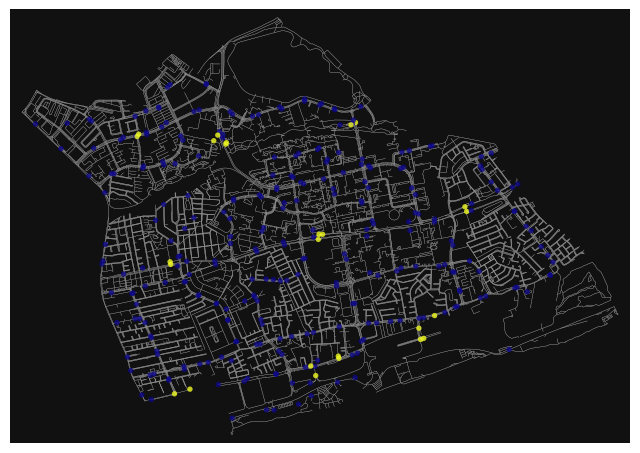

In [208]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for node in bus_nodes:
    node_colors[node] = iso_colors[0]
for node in train_nodes:
    node_colors[node] = iso_colors[1]
nc = [node_colors[node] if node in node_colors else "none" for node in G_pa.nodes()]
ns = [15 if node in node_colors else 0 for node in G_pa.nodes()]
fig, ax = ox.plot_graph(
    G_pa,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

“Pedestrians can now enjoy a sheltered walk within 400m from all MRT stations and within 200m from bus interchanges, LRT stations and selected bus stops with high commuter volumes.”

In [ ]:
def make_iso_polys(subgraph, edge_buff=25, node_buff=50, infill=False):
    """ 
    Args:
        subgraph (MultiGraph): Graph
        edge_buff (int): buffer around edge
        node_buff (int): buffer around nodes
        infill (bool): if True, return gpd.geoseries, else, return Polygon
    Returns:
        Polygon that covers all the nodes in the subgraph
    """
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    # create a geometry based on the nodes
    nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
    nodes_gdf = nodes_gdf.set_index("id")

    edge_lines = []
    for n_fr, n_to in subgraph.edges():
        f = nodes_gdf.loc[n_fr].geometry
        t = nodes_gdf.loc[n_to].geometry
        edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
        edge_lines.append(edge_lookup)

    n = nodes_gdf.buffer(node_buff).geometry
    e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
    all_gs = list(n) + list(e)
    new_iso = gpd.GeoSeries(all_gs).union_all()

    # try to fill in surrounded areas so shapes will appear solid and
    # blocks without white space inside them
    if infill:
        new_iso = Polygon(new_iso.exterior)

    return new_iso